(All programs were run on macOS, intel, 4 cores (8 logical cores), 8GB RAM)

EXERCISE 1: Profiling the Julia Code

In [1]:
# Task 1.1 Calculate the Clock Granularity of different Python Timers (on your system)

# As part of the task measure and report the clock granularity (measured experimentally on your system) for 1) time.time(), 2) timeit and 3) time.time_ns() 
# (for the last one remember that time is outputted in ns!).

import numpy as np
import time
from timeit import default_timer as timer

def clock_granularity_time_time():
   M = 200
   timesfound = np.empty((M,))
   for i in range(M):
      t1 =  time.time()
      t2 = time.time()
      while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
          t2 = time.time()
      t1 = t2 # this is outside the loop
      timesfound[i] = t1 # record the time stamp
   minDelta = 1000000
   Delta = np.diff(timesfound) # it should be cast to int only when needed
   minDelta = Delta.min()
   return minDelta

def clock_granularity_timeit():
   M = 200
   timesfound = np.empty((M,))
   for i in range(M):
      t1 =  timer()
      t2 = timer()
      while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
          t2 = timer()
      t1 = t2 # this is outside the loop
      timesfound[i] = t1 # record the time stamp
   minDelta = 1000000
   Delta = np.diff(timesfound) # it should be cast to int only when needed
   minDelta = Delta.min()
   return minDelta


def clock_granularity_time_time_ns():
   M = 200
   timesfound = np.empty((M,))
   for i in range(M):
      t1 = time.time_ns()
      t2 = time.time_ns()
      while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
          t2 = time.time_ns()
      t1 = t2 # this is outside the loop
      timesfound[i] = t1 # record the time stamp
   minDelta = 1000000
   Delta = np.diff(timesfound) # it should be cast to int only when needed
   minDelta = Delta.min()
   return minDelta

granularity_time_time = clock_granularity_time_time()
granularity_timeit = clock_granularity_timeit()
granularity_time_time_ns = clock_granularity_time_time_ns() / 1_000_000_000
print("Results:")
print("time.time(): ", granularity_time_time)
print("timeit: ", granularity_timeit)
print("time.time_ns(): ", granularity_time_time_ns)

Results:
time.time():  7.152557373046875e-07
timeit:  2.5398912839591503e-07
time.time_ns():  7.68e-07


As we can see, the timeit timer has the smallest clock granularity therefore the highest precision. However, they are all within the same order of magnitude and so have the similar precision levels.

In [2]:
# Task 1.2 Timing the Julia set code functions.

"""
The goal is to time the calc_pure_python and calculate_z_serial_purepython. 
We ask you to develop a decorator to wrap the functions to be profiled for this task. 
Use the decorator to add timer functionality for time measurements with the best timer you found in the previous task. 

As part of the task:
    - Develop the timer decorator 
    - Provide timing information for the two functions. Report averages and standard deviation. How does the standard deviation compare to the clock frequency?
"""

# ------------------------- JULIA CODE ----------------------------------------
"""Julia set generator without optional PIL-based image drawing"""
import time
import numpy as np
from functools import wraps
from timeit import default_timer as timer

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

# decorator to time
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = timer()
        result = fn(*args, **kwargs)
        t2 = timer()
        timing = t2-t1
        if fn.__name__ == "calc_pure_python":
            calc_pure_python_timings.append(timing)
        else:
            calc_z_serial_timings.append(timing)
        return result
    return measure_time

@timefn
def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function

    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    output = calculate_z_serial_purepython(max_iterations, zs, cs)

    # This sum is expected for a 1000^2 grid with 300 iterations
    # It ensures that our code evolves exactly as we'd intended
    # assert sum(output) == 33219980

@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

if __name__ == "__main__":

    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    calc_pure_python_timings = []
    calc_z_serial_timings = []
    
    for i in range(100):
        calc_pure_python(desired_width=1000, max_iterations=300)
    
    calc_pure_python_timings = np.array(calc_pure_python_timings)
    calc_z_serial_timings = np.array(calc_z_serial_timings)

    calc_pure_python_mean = np.mean(calc_pure_python_timings)
    calc_z_serial_mean = np.mean(calc_z_serial_timings)

    calc_pure_python_std = np.std(calc_pure_python_timings)
    calc_z_serial_std = np.std(calc_z_serial_timings)

  
    print("average time taken to execute calc_pure_python: ", calc_pure_python_mean)
    print("average time taken to execute calc_z_serial: ", calc_z_serial_mean)

    print("standard deviation of time taken to execute calc_pure_python: ", calc_pure_python_std)
    print("standard deviation of time taken to execute calc_z_serial:", calc_z_serial_std)

# -------------------------------------------------------------------------------

In [ ]:
# Task 1.3 Profile the Julia set code with cProfile and line_profiler the computation

"""
Use the cProfile and line_profiler to profile the computation in JuliaSet code.

As part of the task:

     -  Report the results of cProfile and line_profiler (for the two functions)

     - Use SnakeViz to visualize the profiling information from cProfile

     - Measure the overhead added by using cProfile and line_profiler. For this, you can time the code with and without  the profilers 
"""

#---------- Profiling using cprofile ------------
#To print cProfile data in the terminal:
!python3 -m cProfile -s cumulative JuliaSet.py

In [ ]:
#To have cProfile output performance statistics to a file:
!python3 -m cProfile -o profile.stats JuliaSet.py

In [ ]:
#Then, we can either use the "readStats.py" file to sort and display the data in terminal:
!pip3 install pstats
!python3 readStats.py

In [ ]:

#Or we can use snakeviz to visualise the data, which displays the data on a browser page
!pip3 install snakeviz
!python3 -m snakeviz profile.stats --server

In [ ]:
#---------- Profiling using line profiler ------------
# By adding "@profile" in the line above the calc_pure_python and calculate_z_serial_purepython functions, we get data on the duration of each line within these functions
# We print this data to terminal by using the following two commands:
# (JuliaSetWithProfile.py is identical to JuliaSet.py, but with the profile wrapper added to the functions)
!python3 -m kernprof -l JuliaSetWithProfile.py
!python3 -m line_profiler JuliaSetWithProfile.py.lprof

In [10]:
# #---------- Measuring the overhead of using these two tools: ------------
# #The file JuliaSetTiming.py is identical to JuliaSet.py, but it also measures the time it takes to execute the calc_pure_python function
# #Without any tools:
print("Without timing, calc_pure_python takes this long in seconds:")
!python3 JuliaSetTiming.py

#Using c profile tool:
print("Using the c profile tool, calc_pure_python takes this long in seconds:")
!python3 -m cProfile -o profile.stats JuliaSetTiming.py

#Using line profiling tool: (we use JuliaSetTimingLineProfile because it also incudes the @profile wraps needed)
print("Using the line profiling tool, calc_pure_python takes this long in seconds:")
!python3 -m kernprof -l JuliaSetTimingLineProfile.py

function took this long: 
0.014415491983527318
function took this long: 
0.03183580600307323
function took this long: 
0.19322470400948077
Wrote profile results to JuliaSetTimingLineProfile.py.lprof
Inspect results with:
python3 -m line_profiler -rmt "JuliaSetTimingLineProfile.py.lprof"


We can see from the results that the timeit timer has the smallest granularity, and is therefore the most accurate. However, all of the results are in the same order of magnitude, and so are very similar.

In [1]:
#Task 1.4 Memory-profile the Juliaset code. Use the memory_profiler and mprof to profile the computation in JuliaSet code
"""
Use memory_profiler to profile the memory usage for the two functions and use mprof to collect and visualize the profiling information.

As part of the task:

    - Report the memory profiling results from memory_profiler and mprof (including the plot)

    - Measure the overhead of memory_profiler and mprof.
"""
!pip3 install memory_profiler
!pip3 install psutil


Length of x: 100
Total elements: 10000
calculate_z_serial_purepython took 0.010776042938232422 seconds
Wrote profile results to JuliaSet.py.lprof
Inspect results with:
python3 -m line_profiler -rmt "JuliaSet.py.lprof"
Timer unit: 1e-06 s



In [22]:
#Using memory profiler
!python3 -m memory_profiler JuliaSetWithProfile.py

Length of x: 100
Total elements: 10000
calculate_z_serial_purepython took 6.672461986541748 seconds
Filename: JuliaSetWithProfile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    20   38.664 MiB   38.664 MiB           1   @profile
    21                                         def calc_pure_python(desired_width, max_iterations):
    22                                             """Create a list of complex coordinates (zs) and complex parameters (cs),
    23                                             build Julia set"""
    24   38.668 MiB    0.004 MiB           1       x_step = (x2 - x1) / desired_width
    25   38.668 MiB    0.000 MiB           1       y_step = (y1 - y2) / desired_width
    26   38.668 MiB    0.000 MiB           1       x = []
    27   38.668 MiB    0.000 MiB           1       y = []
    28   38.668 MiB    0.000 MiB           1       ycoord = y2
    29   38.672 MiB    0.004 MiB         101       while ycoord > y1:
    30   38.672 MiB    0.000 MiB

In [20]:
# This command saves the output to a file named mprofile_20240130... or similar
!python3 -m mprof run JuliaSet.py

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
Length of x: 100
Total elements: 10000
calculate_z_serial_purepython took 0.010042190551757812 seconds


In [21]:
# Change the name of the file at the end of this command to be identical with the one produced by the previous command
!python3 -m mprof plot mprofile_20240130190552.dat

Figure(1260x540)


In [24]:
# #---------- Measuring the overhead of using these two tools: ------------
# #The file JuliaSetTiming.py is identical to JuliaSet.py, but it also measures the time it takes to execute the calc_pure_python function
# #Without any tools:
print("Without timing, calc_pure_python takes this long in seconds:")
!python3 JuliaSetTiming.py

#Using memory profile tool:
print("Using the memory profile tool, calc_pure_python takes this long in seconds:")
!python3 -m memory_profiler JuliaSetTimingLineProfile.py

#Using mprof tool: (we use JuliaSetTimingLineProfile because it also incudes the @profile wraps needed)
print("Using the mprof tool, calc_pure_python takes this long in seconds:")
!python3 -m mprof run JuliaSetTiming.py

Without timing, calc_pure_python takes this long in seconds:
0.015067812986671925
Using the memory profile tool, calc_pure_python takes this long in seconds:
6.589824572991347
Filename: JuliaSetTimingLineProfile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    60   49.043 MiB   49.043 MiB           1   @profile
    61                                         def calculate_z_serial_purepython(maxiter, zs, cs):
    62                                             """Calculate output list using Julia update rule"""
    63   49.047 MiB    0.004 MiB           1       output = [0] * len(zs)
    64   49.062 MiB    0.000 MiB       10001       for i in range(len(zs)):
    65   49.062 MiB    0.000 MiB       10000           n = 0
    66   49.062 MiB    0.000 MiB       10000           z = zs[i]
    67   49.062 MiB    0.000 MiB       10000           c = cs[i]
    68   49.062 MiB    0.012 MiB       66182           while abs(z) < 2 and n < maxiter:
    69   49.062 MiB    0.004 MiB  

EXERCISE 2: PROFILING DIFFUSION PROCESS CODE

In [4]:
#---------- 2.1 Profiling using cProfile ------------
#To print cProfile data in the terminal:
!python3 -m cProfile -s cumulative diffusion.py

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
         35 function calls in 4.069 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.069    4.069 {built-in method builtins.exec}
        1    0.006    0.006    4.069    4.069 diffusion.py:1(<module>)
        1    0.042    0.042    4.063    4.063 diffusion.py:16(run_experiment)
       10    3.995    0.400    4.018    0.402 diffusion.py:2(evolve)
       10    0.023    0.002    0.023    0.002 diffusion.py:4(<listcomp>)
        1    0.003    0.003    0.003    0.003 diffusion.py:19(<listcomp>)
       10    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [5]:
#To have cProfile output performance statistics to a file:
!python3 -m cProfile -o profile.stats diffusion.py

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


In [6]:
#Then, we can either use the "readStats.py" file to sort and display the data in terminal:
!pip3 install pstats
!python3 readStats.py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement pstats (from versions: none)
ERROR: No matching distribution found for pstats
Tue Jan 30 18:51:13 2024    profile.stats

         35 function calls in 4.182 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.182    4.182 {built-in method builtins.exec}
        1    0.005    0.005    4.182    4.182 diffusion.py:1(<module>)
        1    0.043    0.043    4.177    4.177 diffusion.py:16(run_experiment)
       10    4.117    0.412    4.132    0.413 diffusion.py:2(evolve)
       10    0.014    0.001    0.014    0.001 diffusion.py:4(<listcomp>)
        1    0.002    0.002    0.002  

In [7]:
#Or we can use snakeviz to visualise the data, which displays the data on a browser page
!pip3 install snakeviz
!python3 -m snakeviz profile.stats --server

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2F15ajones0201%2FDocuments%2FProfiling-Code%2Fprofile.stats
^C

Bye!


In [8]:
#---------- Profiling using line profiler ------------
!pip3 install line_profiler
!python3 -m kernprof -l diffusionWithProfile.py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.7 MB/s eta 0:00:00
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
Wrote profile results to diffusionWithProfile.py.lprof
Inspect resu

In [10]:
#--------- 2.2: Memory profiler ------------
!pip3 install memory_profiler
!pip3 install psutil

^C
ERROR: Operation cancelled by user


In [12]:
# Memory profiler. Large overhead, so a smaller problem size was used
!python3 -m memory_profiler diffusion_smaller.py

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


In [13]:
# This command saves the output to a file named mprofile_20240130... or similar
!python3 -m mprof run diffusion.py

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


In [16]:
# Change the name of the file to be identical with the one produced by the previous command
!python3 -m mprof plot mprofile_20240130185310.dat

Figure(1260x540)


Bonus Exercise: Develop your profiler tool for monitoring CPU percentage use with psutil

number of cores is:  8
done


times:
[0.0, 2.019690990447998, 4.0398640632629395, 6.061202049255371, 8.079986095428467, 10.101186990737915, 12.11588716506958, 14.134951114654541, 16.15485405921936, 18.175689935684204, 20.195611000061035, 22.216203927993774, 24.232745885849, 26.251216173171997]
core results:
[array([74.3, 70.6, 57.4, 68. , 65.3, 60.8, 64.4, 62. , 64.7, 61. , 66.7,
       80.2, 87.1, 85.1]), array([14.9,  8. ,  5. ,  6.9,  7.9,  5. ,  5.1,  6.9,  7. ,  6.9,  5.9,
       15.7, 13.9, 11.9]), array([68.3, 64.4, 52. , 59.8, 59. , 54.5, 60.4, 57.8, 59.4, 56. , 57.4,
       78. , 84.3, 80.2]), array([ 9.9,  7. ,  4. ,  5. ,  6.9,  5. ,  5.9,  5. ,  6.9,  5. ,  5.9,
       12.9, 13.9, 11.9]), array([71.3, 64.7, 52. , 57.8, 60. , 53.5, 54.5, 55.4, 56.4, 56.9, 57.4,
       77.2, 84.2, 79.2]), array([11.9,  8.8,  3. ,  5.9,  5. ,  5. ,  5. ,  4. ,  5.9,  5. ,  4. ,
       15.8, 12.9,  8.9]), array([65.7, 64.7, 47.5, 57.4, 55.9, 50. , 50.5, 52. , 57.4, 51.5, 52.9,
       73.3, 83.2, 80.2]), array([11.9,  6. ,  

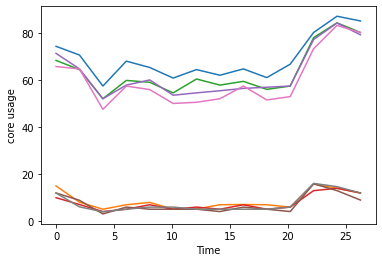

In [ ]:
# BONUS - Develop your profiler tool for monitoring CPU percentage use with psutil

# ------------------------- JULIA CODE ----------------------------------------
"""Julia set generator without optional PIL-based image drawing"""
import time
import psutil
import numpy as np
from functools import wraps
from timeit import default_timer as timer
import threading
import matplotlib.pyplot as plt 

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function

    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    output = calculate_z_serial_purepython(max_iterations, zs, cs)

    # This sum is expected for a 1000^2 grid with 300 iterations
    # It ensures that our code evolves exactly as we'd intended
    # assert sum(output) == 33219980

def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


if __name__ == "__main__":
    num_cores = psutil.cpu_count()
    print("number of cores is: ", num_cores)

    def count_cpu_usage():
        #This thread monitors cpu usage while running the julia set code. every second it reads the cpu usage value for each core,
        #until the julia set code terminates, and function_active becomes false
        #afterwards, it plots a usage vs time graph for each of the cores.
        results = []
        times = []
        start_time = time.time()
        while function_active:
            current_time = time.time()-start_time
            x = psutil.cpu_percent(interval=1, percpu=True)
            times.append(current_time)
            results.append(x)
            time.sleep(1)
        results = np.array(results)
        print("times:")
        print(times)
        core_results = [results[:, i] for i in range(results.shape[1])]
        print("core results:")
        print(core_results)
        for i, core_result in enumerate(core_results):
            label = "core  " + str(i)
            plt.plot(times, core_result, label=label)
        plt.xlabel('Time')
        plt.ylabel('core usage')
        plt.show()


    function_active = True
    #create and start the thread that monitors cpu usage
    t = threading.Thread(target=count_cpu_usage)
    t.start()
    #calculate julia set
    calc_pure_python(desired_width=2000, max_iterations=300)
    #inform the thread that monitors usage that the program has terminated
    function_active = False
    print("done")




# -------------------------------------------------------------------------------